<a href="https://colab.research.google.com/github/swilsonmfc/bayesian/blob/main/LinearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian Linear Regression

![](https://scx2.b-cdn.net/gfx/news/hires/2013/bayestheorem.jpg)

# Install

In [1]:
!pip install arviz==0.6.1
!pip install pymc3==3.8
!pip install Theano==1.0.4

# Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

import arviz as az
import pymc3 as pm
from pymc3.glm import GLM

import statsmodels.api as sm
from statsmodels.formula.api import glm as glm_sm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data
* Data is from Rethinking Statistics - McElreath

In [3]:
df = pd.read_csv('https://github.com/rmcelreath/rethinking/raw/master/data/Howell1.csv', sep=';')

In [4]:
df

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0
...,...,...,...,...
539,145.415,31.127751,17.0,1
540,162.560,52.163080,31.0,1
541,156.210,54.062496,21.0,0
542,71.120,8.051258,0.0,1


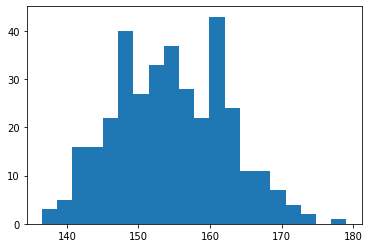

In [5]:
H = df[df.age >= 18]['height']
W = df[df.age >= 18]['weight']
plt.hist(H, bins=20);

Text(0, 0.5, 'Height')

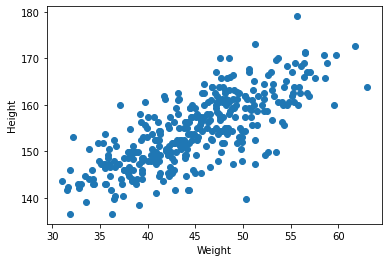

In [6]:
plt.scatter(W, H)
plt.xlabel('Weight')
plt.ylabel('Height')

# Linear Model
![](https://miro.medium.com/max/2872/1*k2bLmeYIG7z7dCyxADedhQ.png)

# Weight Model

In [7]:
data_df = df[df.age >= 18].copy()

## Model
* Assumptions of a linear model 
  * Linearly related
  * Independent
  * Normally distributed error / residuals
  * Errors are constant - No heteroskedasicity
* All parameters have a prior

In [8]:
with pm.Model() as lm:
  alpha  = pm.Normal('alpha', 170, 10)
  weight = pm.Normal('weight', 0, 10)
  sigma  = pm.Uniform('sigma', 0, 20)
  mu = alpha + weight * data_df['weight']
  height = pm.Normal('height', mu=mu, sigma=sigma, observed=data_df['height'])  
  traces = pm.sample(1000, tune=1000, init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, weight, alpha]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:05<00:00, 336.52it/s]


## Plot
* The unscaled model had an explanation of a 1 unit change in weight corresponded to a 0.86 change in height
* The intercept was nonsensical though, you had a height of 115.75 when weight = 0

/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not 

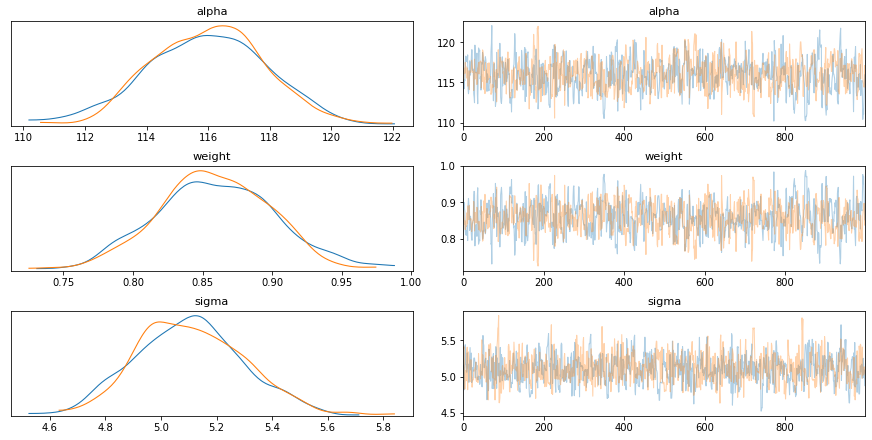

In [9]:
pm.traceplot(traces);

## Summary

In [10]:
az.summary(traces, round_to=2)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,116.00,1.92,112.28,119.44,0.08,0.05,617.67,617.67,619.18,709.42,1.0
weight,0.86,0.04,0.78,0.94,0.00,0.00,612.61,612.36,616.11,736.22,1.0
sigma,5.11,0.19,4.76,5.46,0.01,0.00,834.02,834.02,825.22,810.94,1.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f534ddd6fd0>,
      dtype=object)

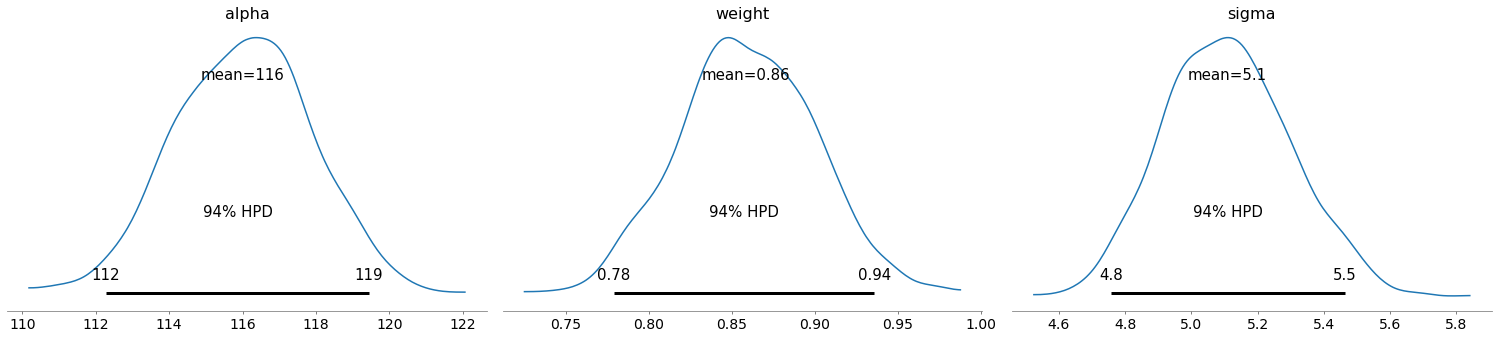

In [11]:
az.plot_posterior(traces)

## Statsmodels

In [12]:
m = glm_sm('height ~ weight', data_df, 
           family=sm.families.Gaussian()).fit()
print(m.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 height   No. Observations:                  352
Model:                            GLM   Df Residuals:                      350
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                          25.871
Method:                          IRLS   Log-Likelihood:                -1071.0
Date:                Thu, 10 Dec 2020   Deviance:                       9054.8
Time:                        14:22:54   Pearson chi2:                 9.05e+03
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    113.8794      1.911     59.589      0.0

## Posterior

100%|██████████| 2000/2000 [00:02<00:00, 718.82it/s]


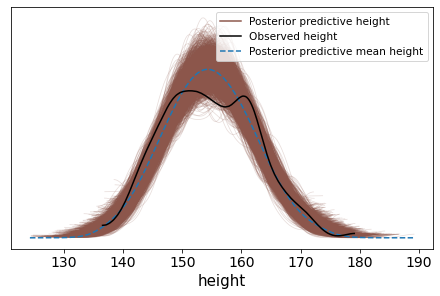

In [13]:
with lm:
    ppc = pm.sample_posterior_predictive(traces, random_seed=1)
idata = az.from_pymc3(traces, posterior_predictive=ppc)
az.plot_ppc(idata);

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f53427dfa90>],
      dtype=object)

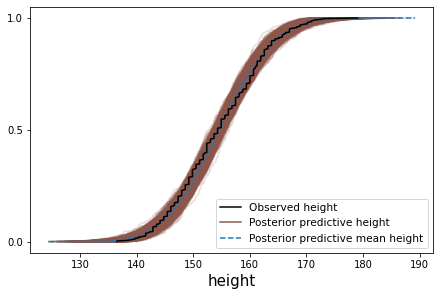

In [14]:
az.plot_ppc(idata, kind='cumulative')

# Scaled Model
* The regressors are in actual scale, but this can lead to numerical instability in fitting
* To improve convergence, let's scale the data
* This subtracts the mean and divides by standard deviation

## Scale

In [15]:
data_df = df.copy()
for col in ['weight']:
  scaler = StandardScaler()
  data_df[col] = scaler.fit_transform(data_df[[col]])

## Model

In [16]:
with pm.Model() as lm_scaled:
  alpha  = pm.Normal('alpha', 170, 10)
  weight = pm.Normal('weight', 0, 10)
  sigma  = pm.Uniform('sigma', 0, 20)
  mu = alpha + weight * data_df['weight']
  height = pm.Normal('height', mu=mu, sigma=sigma, observed=data_df['height'])  
  traces = pm.sample(1000, tune=1000, init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, weight, alpha]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1248.05it/s]


## Plot
* The intercept was now makes sense, where the height is 138 when then weight is at the mean
* A one unit change now refers to a one standard deviation change in weight moves the height 25.8 

/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not 

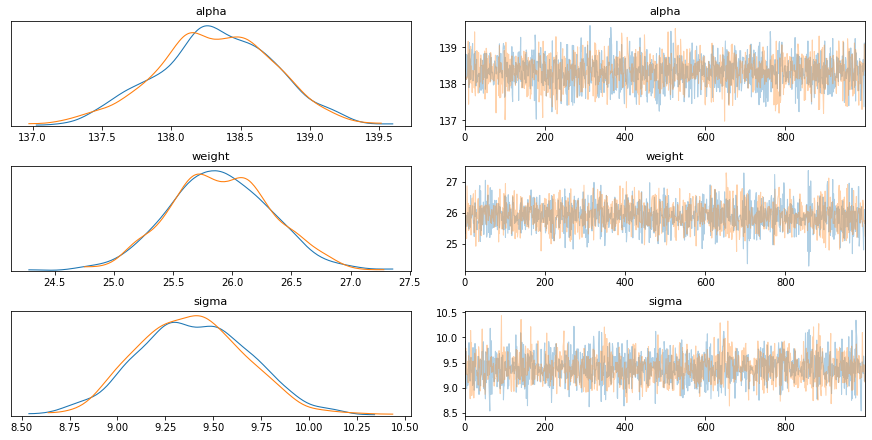

In [17]:
pm.traceplot(traces);

## Summary

In [18]:
az.summary(traces)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,138.318,0.420,137.592,139.179,0.008,0.006,2453.0,2453.0,2443.0,1302.0,1.0
weight,25.901,0.427,25.117,26.700,0.009,0.006,2391.0,2390.0,2430.0,1460.0,1.0
sigma,9.395,0.286,8.902,9.936,0.006,0.004,2168.0,2154.0,2191.0,1470.0,1.0


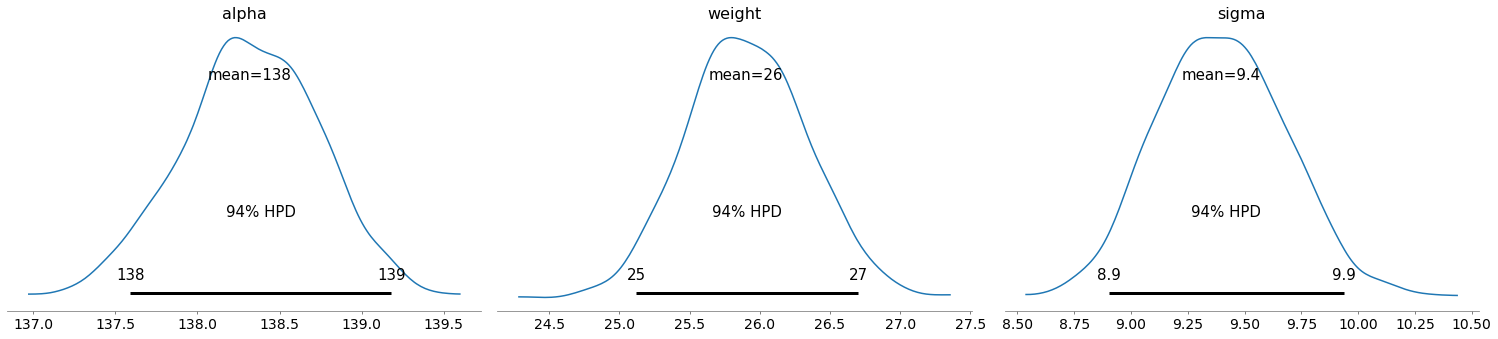

In [19]:
az.plot_posterior(traces);

## Posterior

100%|██████████| 2000/2000 [00:02<00:00, 741.94it/s]


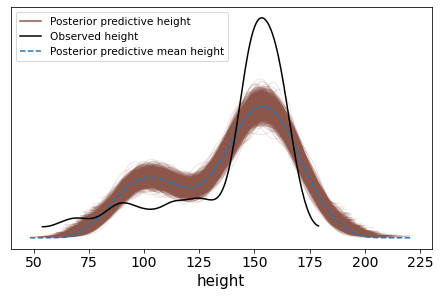

In [20]:
with lm_scaled:
    ppc = pm.sample_posterior_predictive(traces, random_seed=1)
idata = az.from_pymc3(traces, posterior_predictive=ppc)
az.plot_ppc(idata);

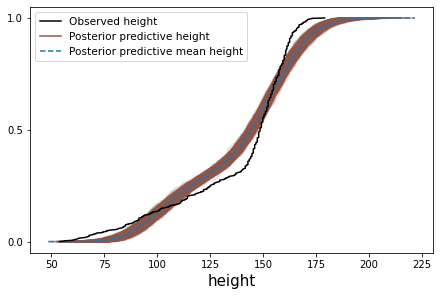

In [21]:
az.plot_ppc(idata, kind='cumulative');

# Priors

![](https://www.researchgate.net/profile/Hideyoshi_Yanagisawa2/publication/330577376/figure/fig1/AS:718458304086017@1548305216392/Example-of-Bayesian-inference-with-a-prior-distribution-a-posterior-distribution-and.png)

## Flat Priors
* Flat priors indicate no prior knowledge
* Flat priors are consistent with frequentist approaches

In [22]:
with pm.Model() as lm_flat:
  alpha  = pm.Uniform('alpha', 0, 1000)
  weight = pm.Uniform('weight', -1000, 1000)
  sigma  = pm.Uniform('sigma', 0, 1000)
  mu = alpha + weight * data_df['weight']
  height = pm.Normal('height', mu=mu, sigma=sigma, observed=data_df['height'])  
  traces = pm.sample(1000, tune=1000, init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, weight, alpha]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1139.37it/s]


/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5342d546d8>,
      dtype=object)

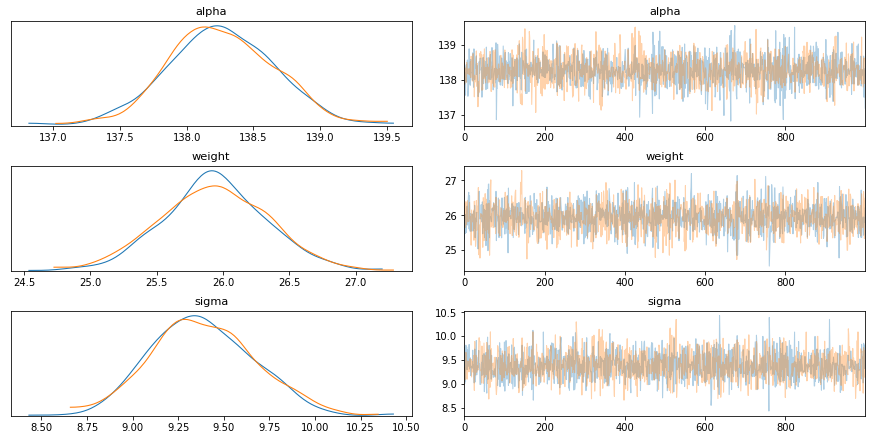

In [23]:
pm.traceplot(traces)

In [24]:
az.summary(traces)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,138.260,0.405,137.496,138.996,0.008,0.006,2397.0,2397.0,2407.0,1204.0,1.0
weight,25.934,0.395,25.213,26.704,0.008,0.005,2741.0,2741.0,2749.0,1424.0,1.0
sigma,9.385,0.281,8.859,9.890,0.006,0.004,2548.0,2536.0,2563.0,1451.0,1.0


In [25]:
m = glm_sm('height ~ weight', data_df, 
           family=sm.families.Gaussian()).fit()
print(m.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 height   No. Observations:                  544
Model:                            GLM   Df Residuals:                      542
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                          87.668
Method:                          IRLS   Log-Likelihood:                -1987.7
Date:                Thu, 10 Dec 2020   Deviance:                       47516.
Time:                        14:23:52   Pearson chi2:                 4.75e+04
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    138.2636      0.401    344.419      0.0

## Strong Prior
* Our weak prior around alpha was Normal(170, 10)
* What happens if we add a strong prior, Normal(170, 0.1) around 170?
* This effectively says, I know people are 170 cm tall.

In [26]:
with pm.Model() as lm_strong:
  alpha  = pm.Normal('alpha', 170, .1)
  weight = pm.Normal('weight', 0, 10)
  sigma  = pm.Uniform('sigma', 0, 20)
  mu = alpha + weight * data_df['weight']
  height = pm.Normal('height', mu=mu, sigma=sigma, observed=data_df['height'])  
  traces = pm.sample(1000, tune=1000, init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, weight, alpha]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1087.19it/s]


/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not 

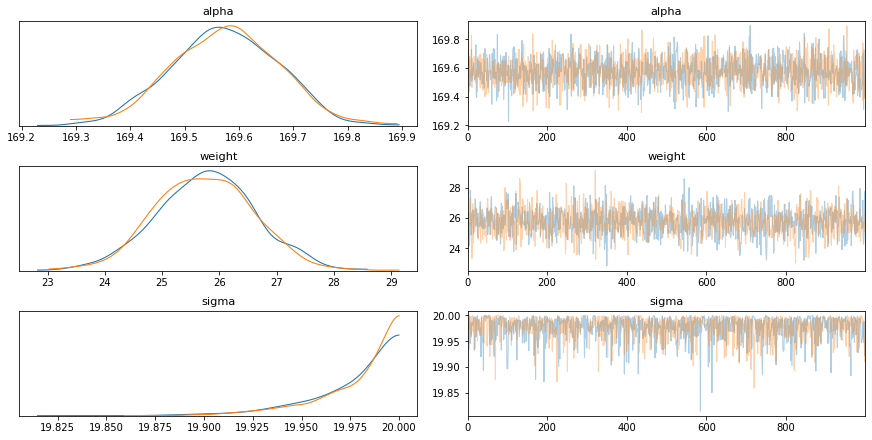

In [27]:
pm.traceplot(traces);

* Our weak prior allowed the model to adjust the intercept to 138
* With very strong prior, the data couldn't escape it
* Our alpha was as 169.5, but our measurement of sigma had to adjust to the data
* Sigma increased from 9.3 to 19.98

In [28]:
az.summary(traces)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,169.574,0.098,169.389,169.746,0.002,0.002,2090.0,2090.0,2094.0,1518.0,1.00
weight,25.759,0.856,24.250,27.407,0.021,0.015,1637.0,1637.0,1641.0,1197.0,1.00
sigma,19.977,0.023,19.933,20.000,0.001,0.000,1530.0,1530.0,882.0,439.0,1.01


# Full Data
* In the prior examples we looked at height - weight relationship of adults
* Now, let's dig through the entire dataset
* The full dataset is non-linear

Text(0.5, 1.0, 'Height by Age')

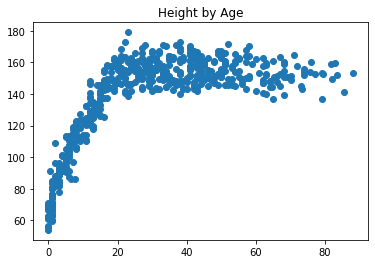

In [29]:
plt.scatter(df.age, df.height)
plt.title('Height by Age')

Text(0.5, 1.0, 'Height by Weight')

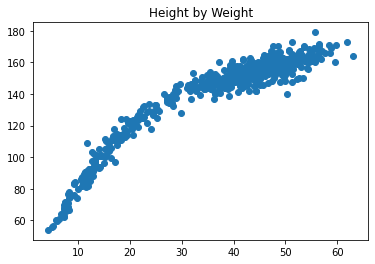

In [30]:
plt.scatter(df.weight, df.height)
plt.title('Height by Weight')

# Underfit
* We have a model that can fit a straight line to the data
* What's the best / most plausible straight line?

## Scale

In [31]:
under_df = df.copy()
for col in ['weight']:
  scaler = StandardScaler()
  under_df[col] = scaler.fit_transform(under_df[[col]])

## Model

In [32]:
with pm.Model() as lm_underfit:
  alpha  = pm.Normal('alpha', 170, 10)
  weight = pm.Normal('weight', 0, 10)
  sigma  = pm.Uniform('sigma', 0, 50)
  mu = alpha + weight * under_df['weight']
  height = pm.Normal('height', mu=mu, sigma=sigma, observed=under_df['height'])  
  traces = pm.sample(1000, tune=1000, init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, weight, alpha]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1258.53it/s]


## Plot
* The intercept was now makes sense, where the height is 138 when then weight is at the mean
* A one unit change now refers to a one standard deviation change in weight moves the height 25.8 

/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not 

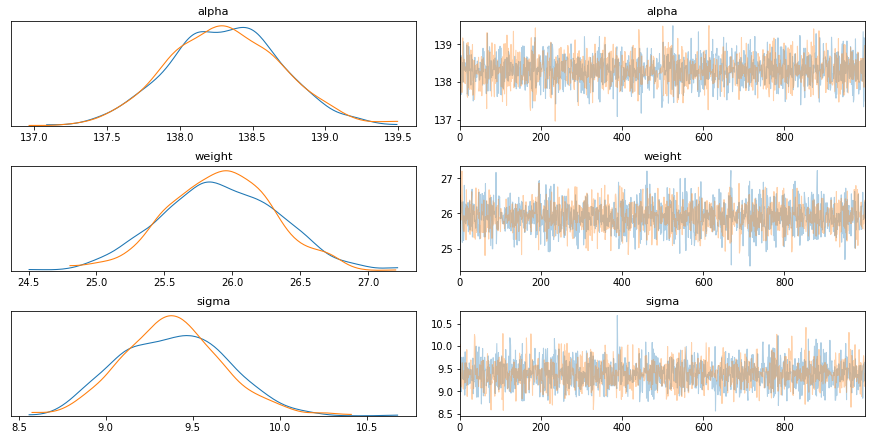

In [33]:
pm.traceplot(traces);

## Summary

In [34]:
az.summary(traces)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,138.311,0.382,137.608,139.021,0.007,0.005,3072.0,3071.0,3064.0,1567.0,1.0
weight,25.912,0.406,25.213,26.721,0.007,0.005,3195.0,3189.0,3183.0,1496.0,1.0
sigma,9.387,0.293,8.868,9.934,0.006,0.004,2762.0,2744.0,2771.0,1493.0,1.0


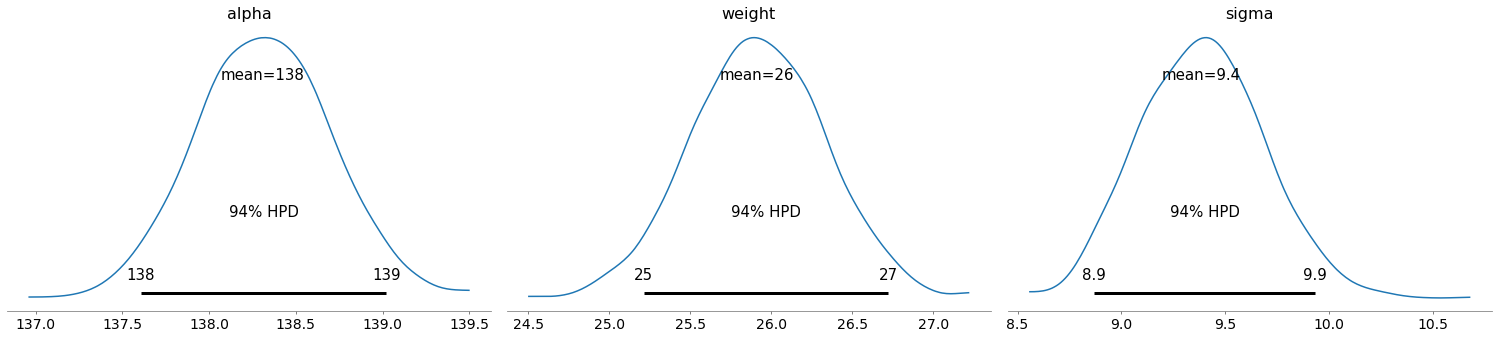

In [35]:
az.plot_posterior(traces);

## Posterior

100%|██████████| 2000/2000 [00:02<00:00, 747.39it/s]


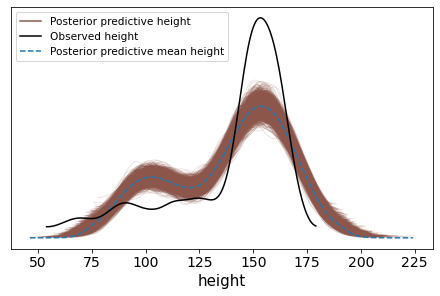

In [36]:
with lm_underfit:
    ppc = pm.sample_posterior_predictive(traces, random_seed=1)
idata = az.from_pymc3(traces, posterior_predictive=ppc)
az.plot_ppc(idata);

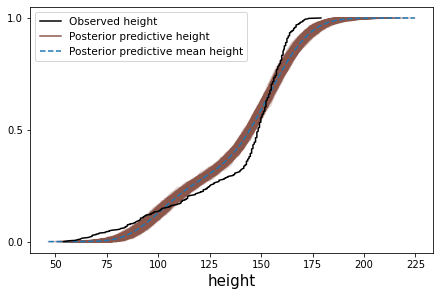

In [37]:
az.plot_ppc(idata, kind='cumulative');

# Quadratic Terms
* We can fit non-linear relationships using quadratic terms
* If we fit one quadratic, it'll be more parabolic in shape
* Adding additional terms will give the fit more opportunity to bend
* Other approaches to this problem can be using piecewise regression / splines

## Scale

In [38]:
quad_df = df.copy()
for col in ['weight']:
  scaler = StandardScaler()
  quad_df[col] = scaler.fit_transform(quad_df[[col]])
quad_df['weight2'] = quad_df.weight ** 2

## Model

In [39]:
with pm.Model() as lm_quad:
  alpha  = pm.Normal('alpha', 170, 100)
  weight = pm.Normal('weight', 0, 10)
  weight2 = pm.Normal('weight2', 0, 10)
  sigma  = pm.Uniform('sigma', 0, 50)
  mu = alpha + weight * quad_df['weight'] + weight2 * quad_df['weight2']
  height = pm.Normal('height', mu=mu, sigma=sigma, observed=quad_df['height'])  
  traces = pm.sample(1000, tune=1000, init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, weight2, weight, alpha]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 828.59it/s]


## Plot

/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not 

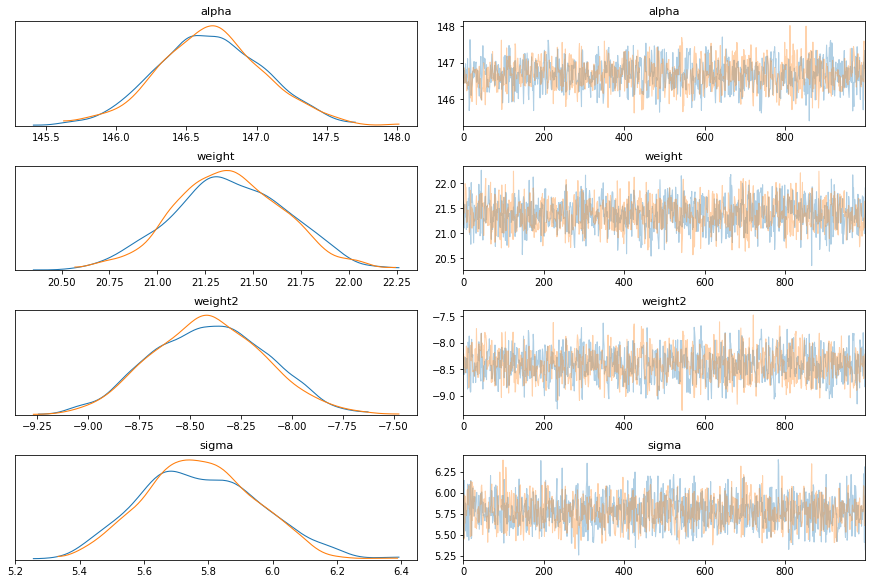

In [40]:
pm.traceplot(traces);

## Summary

In [41]:
az.summary(traces)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,146.675,0.376,145.960,147.376,0.011,0.008,1205.0,1205.0,1206.0,1494.0,1.0
weight,21.379,0.292,20.832,21.923,0.008,0.005,1490.0,1490.0,1493.0,1593.0,1.0
weight2,-8.407,0.278,-8.931,-7.916,0.008,0.006,1229.0,1229.0,1229.0,1270.0,1.0
sigma,5.777,0.178,5.463,6.109,0.004,0.003,1601.0,1597.0,1611.0,1225.0,1.0


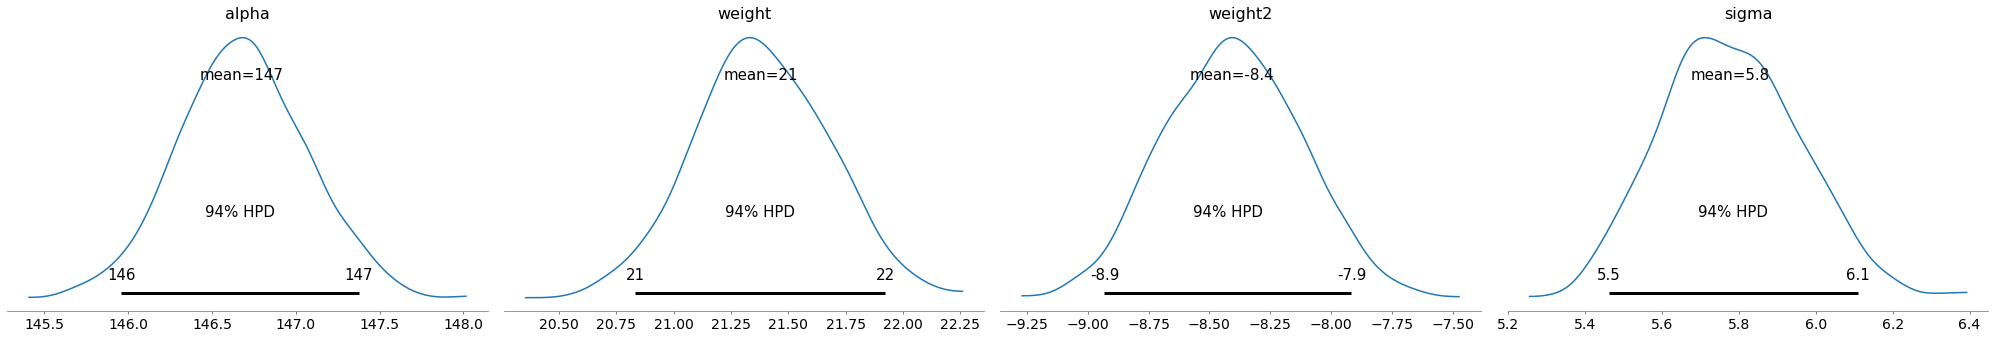

In [51]:
az.plot_posterior(traces);

## Statsmodels

In [42]:
m = glm_sm('height ~ weight + I(weight ** 2)', quad_df, 
           family=sm.families.Gaussian()).fit()
print(m.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 height   No. Observations:                  544
Model:                            GLM   Df Residuals:                      541
Model Family:                Gaussian   Df Model:                            2
Link Function:               identity   Scale:                          33.243
Method:                          IRLS   Log-Likelihood:                -1723.4
Date:                Thu, 10 Dec 2020   Deviance:                       17985.
Time:                        14:24:38   Pearson chi2:                 1.80e+04
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        146.6604      0.375    391.

100%|██████████| 2000/2000 [00:02<00:00, 761.32it/s]


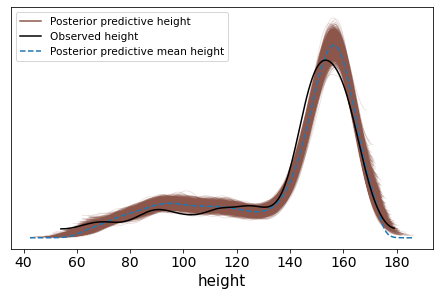

In [43]:
with lm_quad:
    ppc = pm.sample_posterior_predictive(traces, random_seed=1)
idata = az.from_pymc3(traces, posterior_predictive=ppc)
az.plot_ppc(idata);

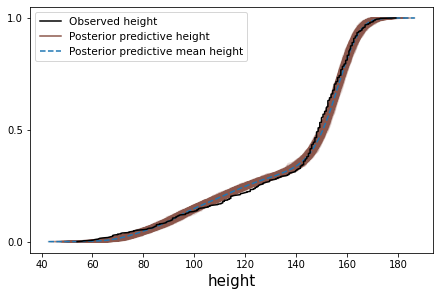

In [44]:
az.plot_ppc(idata, kind='cumulative');